# Black Lives Matter: Topic Modeling

### This pipeline is intended to retrieve and model topics for Tweets containing terms related to Michael Brown but not Ferguson

This analysis was inspired by the [_Topic Modeling with Gensim (Python)_ post](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), which can be found on the Machine Learning Plus blog.

This version of the pipeline skips some descriptive steps that can be found on the ferguson_mikebrown.ipynb file.

## Import libraries

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rosarodriguez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter
import random

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq

In [4]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, ldamodel
from gensim.test.utils import datapath

In [5]:
# spacy for lemmatization
import spacy

In [6]:
# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [7]:
# Parallelize prediction
import multiprocessing

In [8]:
import pyLDAvis
import pyLDAvis.gensim

In [9]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [10]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['url','ferguson', 'michael', 'mike', 'brown', 'michaelbrown', 'mikebrown'])

## Import data

In [12]:
%env GOOGLE_APPLICATION_CREDENTIALS = ../dsi-capstone-f19-group-1-198add732865.json

env: GOOGLE_APPLICATION_CREDENTIALS=../dsi-capstone-f19-group-1-198add732865.json


In [13]:
%load_ext google.cloud.bigquery

In [14]:
%%bigquery df
SELECT DISTINCT full_text_cleaned AS full_text
FROM tweets.all_valid_tweets
WHERE michael_brown = 1 AND ferguson_ht = 0 AND is_retweet = FALSE

In [15]:
data = list(df['full_text'])

## Pre-processing tweets

### Decompose into bag of words

Let's take a tweet in our data:

In [16]:
tweet = 'News: Ma who shot video of Eric Garner in apparent choke hold arrested on firearms charges.'
print(tweet)

News: Ma who shot video of Eric Garner in apparent choke hold arrested on firearms charges.


Now we will decompose this tweet into an array of words, where the order doesn't matter.

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
data_words = list(sent_to_words(data))

#Example
tweet_words = list(sent_to_words([tweet]))
print(tweet_words[0])

['news', 'ma', 'who', 'shot', 'video', 'of', 'eric', 'garner', 'in', 'apparent', 'choke', 'hold', 'arrested', 'on', 'firearms', 'charges']


### Stop words

There are commonly used words (such as “the”, “a”, “an”, “in”) which appear that often, that are useless to understand the context we are analyzing. Moreover, since they are common, they make the NLP techniques to spend more time processing, without adding any value. Therefore, we will remove them from every tweet.

In [18]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def unique_list_of_lists(lol):
    unique_lol = set(map(tuple, lol))
    unique_lol = list(map(list, unique_lol))
    return(unique_lol)

# Remove Stop Words
data_words_nostops = unique_list_of_lists(remove_stopwords(data_words))

#Example
tweet_words_nostops = remove_stopwords(tweet_words)
print(tweet_words_nostops[0])

['news', 'shot', 'video', 'eric', 'garner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Bigrams and Trigrams

There are concepts like _Eric Garner_ or _New York_ which make more sense to be analyzed as a single word, than being split into two. To achieve that we will use the concept of bigrams and trigrams.

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [20]:
def make_bigrams(texts):
    return [remove_underscore(bigram_mod[doc]) for doc in texts]

def make_trigrams(texts):
    return [remove_underscore(trigram_mod[bigram_mod[doc]]) for doc in texts]

def remove_underscore(doc):
    return([re.sub("_", "", word) for word in doc])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Example
tweet_words_bigrams = make_bigrams(tweet_words_nostops)
print(tweet_words_bigrams[0])

['news', 'shot', 'video', 'ericgarner', 'apparent', 'chokehold', 'arrested', 'firearms', 'charges']


### Lemmatization

Finally, we would like to tackle one last challenge: The fact that a word used as a singular or plural should be considered the same. Similar case when you conjugate a verb or you use verbs and adjectives with the same origin. 

These kinds of problems are solved by _Lemmatization_ , a technique that transforms any single word to its root.

In [22]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized =  unique_list_of_lists(remove_stopwords(
    lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
))

# Example
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(tweet_lemmatized[0])

['shoot', 'arrest', 'firearm', 'charge']


## Modeling topics

### Build corpora

Once we have the pre-processed tweets we want to model, we need to make them comparable on a mathematical way. To achieve that, we will create as many dimensions as we have unique words in the set of tweets. Then, we will assign to each word the number of times it was mentioned in the tweet (and zero if it didn't appear).

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Example
print(id2word.doc2bow(tweet_lemmatized[0]))

[(32, 1), (114, 1), (249, 1), (3762, 1)]


In [24]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in [id2word.doc2bow(tweet) for tweet in tweet_lemmatized]]

[[('shoot', 1), ('charge', 1), ('arrest', 1), ('firearm', 1)]]

### LDA Model

To model the different topics, we are going to use the Latent Dirichlet Allocation (LDA) technique. Specifically, we are going to use the Mallet implementation, which is a Java-based package for statistical NLP.

### Choosing the right number of topics

As on the original pipeline file, we would like to optimize the hyper-parameter for number of topics, as well to improve the model performance. To achieve that we will use the Coherence Score, trying different values, and analyzing which is the one with the best performance.

In [25]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        mallet_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                            corpus=corpus,
                                            num_topics=num_topics,
                                            id2word=id2word,
                                            alpha=1,
                                            optimize_interval=50,
                                            workers=7,
                                            random_seed=2019)
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
limit = 18
start = 6
step = 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit,
                                                        step=step)

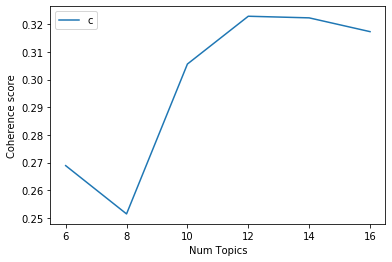

In [28]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 6  has Coherence Value of 0.2689
Num Topics = 8  has Coherence Value of 0.2515
Num Topics = 10  has Coherence Value of 0.3056
Num Topics = 12  has Coherence Value of 0.3229
Num Topics = 14  has Coherence Value of 0.3223
Num Topics = 16  has Coherence Value of 0.3173


### Working with the optimal model

The model that maximized coherence was the one with 12 topics, just like on the other variation.

In [30]:
file_name = 'optimal_model_only_MB'

In [43]:
# optimal_model = model_list[3]
# optimal_model.save(file_name)

In [53]:
optimal_model = ldamodel.LdaModel.load(file_name, mmap='r')
id2word = corpora.Dictionary.load('optimal_model_only_MB.id2word', mmap='r')

In [54]:
# Print the topics
pprint(optimal_model.show_topics(formatted=False, num_topics=20))

[(0,
  [('shoot', 0.1198566814861078),
   ('police', 0.10120226482697413),
   ('officer', 0.06524936928348961),
   ('kill', 0.03916605717948507),
   ('video', 0.019213227378438124),
   ('death', 0.018399664713568416),
   ('release', 0.018112041549220543),
   ('protest', 0.015087889421220016),
   ('shooting', 0.01503036478835044),
   ('news', 0.01258967679374132)]),
 (1,
  [('song', 0.01741818857596594),
   ('tribute', 0.016809988004933184),
   ('listen', 0.01674241016370732),
   ('video', 0.013414201483333615),
   ('make', 0.012687739690155598),
   ('free', 0.012316061563413357),
   ('music', 0.012028855738203443),
   ('shoot', 0.010863137977057322),
   ('hand', 0.010829349056444391),
   ('rip', 0.010474565390008616)]),
 (2,
  [('police', 0.04832554286728596),
   ('death', 0.04345896692503402),
   ('shoot', 0.03663984379622508),
   ('case', 0.028933199218981125),
   ('local', 0.01628601857878232),
   ('investigation', 0.014377847464647063),
   ('call', 0.014289095319803562),
   ('wearc

## Exploring the results

### Dominant topic in each sentence

In [55]:
def create_corpus(data):
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]
    return(corpus)


def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    words = list(sent_to_words(texts))
    
    try:
        cpus = multiprocessing.cpu_count()
    except NotImplementedError:
        cpus = 7   # arbitrary default
    
    pool = multiprocessing.Pool(processes=cpus)
    dom_topics_list = pool.map(get_dominant_topic, list(ldamodel[corpus]))
    pool.close()
    
    df_dominant_topic = pd.DataFrame(dom_topics_list)

    # Add original text to the end of the output
    contents = pd.Series(texts)
    bow = pd.Series(words)
    df_dominant_topic = pd.concat([df_dominant_topic, contents, bow], axis=1).reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text', 'Words']
    
    topic_keywords_dict = get_topic_keywords_dict(ldamodel)
    df_dominant_topic['Topic_Keywords'] = list(map(
        lambda x:topic_keywords_dict[x],
        df_dominant_topic['Dominant_Topic']
    ))
    df_dominant_topic = df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text', 'Words']]
    
    return(df_dominant_topic)


def get_dominant_topic(topics):
    topic_num, prop_topic = sorted(topics, key=lambda x: (x[1]), reverse=True)[0]
    prop_topic = round(prop_topic,4)
    return(topic_num + 1, prop_topic)


def get_topic_keywords_dict(ldamodel):
    topic_keywords_dict = {}
    for topic in ldamodel.show_topics(formatted=False, num_topics=20):
        topic_num, topic_keywords = topic
        topic_num += 1
        topic_keywords = ", ".join([word for word, prop in topic_keywords])
        topic_keywords_dict[topic_num] = topic_keywords
    return(topic_keywords_dict)

In [56]:
corpus_ = create_corpus(data)
df_dominant_topic = format_topics_sentences(optimal_model, corpus_, data)

In [57]:
# Show
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,Words
0,0,10,0.8871,"family, today, parent, peace, mother, pray, justice, rip, son, prayer",stl is off the chain tonight mikebrown please stay safe family,"[stl, is, off, the, chain, tonight, mikebrown, please, stay, safe, family]"
1,1,11,0.8188,"shoot, autopsy, time, shot, head, report, autopsyshow, show, family, body",todays top buzz autopsy shows michael brown was struck at least 6 times $URL$ see more $URL$,"[todays, top, buzz, autopsy, shows, michael, brown, was, struck, at, least, times, url, see, more, url]"
2,2,5,0.5905,"people, situation, make, happen, shit, robinwilliam, talk, thing, death, case",day by day people like mikebrown are being killed by police and people pretend we should sit back and remain silent no,"[day, by, day, people, like, mikebrown, are, being, killed, by, police, and, people, pretend, we, should, sit, back, and, remain, silent, no]"
3,3,5,0.4641,"people, situation, make, happen, shit, robinwilliam, talk, thing, death, case",mike brown mother mad a statement i cant get out my head,"[mike, brown, mother, mad, statement, cant, get, out, my, head]"
4,4,5,0.1358,"people, situation, make, happen, shit, robinwilliam, talk, thing, death, case",watch i am mike brown live from ferguson mo on $URL$,"[watch, am, mike, brown, live, from, ferguson, mo, on, url]"
5,5,4,0.8655,"story, case, shoot, murder, medium, read, news, death, article, fact",nbc affiliate ksdk said it received 13 pages of the michael brown incident report under foia no info on their page follow up?,"[nbc, affiliate, ksdk, said, it, received, pages, of, the, michael, brown, incident, report, under, foia, no, info, on, their, page, follow, up]"
6,6,1,0.9040,"shoot, police, officer, kill, video, death, release, protest, shooting, news",first pics of the police officer who shot and killed unarmed michael brown right is a pic of darren wilson t $URL$,"[first, pics, of, the, police, officer, who, shot, and, killed, unarmed, michael, brown, right, is, pic, of, darren, wilson, url]"
7,7,12,0.6637,"people, black, death, justice, police, murder, protest, kill, issue, violence",thank you for documenting this w great dignity mikebrown’s burial service $URL$ $URL$,"[thank, you, for, documenting, this, great, dignity, mikebrown, burial, service, url, url]"
8,8,10,0.5090,"family, today, parent, peace, mother, pray, justice, rip, son, prayer",family of michael brown wants calm at his funeral $URL$,"[family, of, michael, brown, wants, calm, at, his, funeral, url]"
9,9,1,0.8631,"shoot, police, officer, kill, video, death, release, protest, shooting, news",michael brown shooting us cannot lecture others on human rights amnesty says as egypt appeals for restraint $URL$,"[michael, brown, shooting, us, cannot, lecture, others, on, human, rights, amnesty, says, as, egypt, appeals, for, restraint, url]"


### Most representative tweets

In [58]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
# Group top 5 sentences under each topic
df_dominant_topic_sorted = pd.DataFrame()

df_dominant_topic_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in df_dominant_topic_grpd:
    df_dominant_topic_sorted = pd.concat([df_dominant_topic_sorted, 
                                         grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(10)], 
                                         axis=0)

# Reset Index    
df_dominant_topic_sorted.reset_index(drop=True, inplace=True)

# Format
df_dominant_topic_sorted.columns = ['Document_No','Topic_Num', 'Topic_Perc_Contrib', 'Text', 'Words', 'Topic_Keywords']

# Show
df_dominant_topic_sorted

,Document_No,Topic_Num,Topic_Perc_Contrib,Text,Words,Topic_Keywords
0,342354,1,0.9493,"shoot, police, officer, kill, video, death, release, protest, shooting, news",michael brown shooting police fire tear gas to break up protests police in riot gear fired tear gas into a crowd of protesters tues,"[michael, brown, shooting, police, fire, tear, gas, to, break, up, protests, police, in, riot, gear, fired, tear, gas, into, crowd, of, protesters, tues]"
1,270679,1,0.9450,"shoot, police, officer, kill, video, death, release, protest, shooting, news",“anonymous” tweets name of officer who shot michael brown; claims address photo docs will follow if ferguson pd doesn’t respond,"[anonymous, tweets, name, of, officer, who, shot, michael, brown, claims, address, photo, docs, will, follow, if, ferguson, pd, doesn, respond]"
2,240104,1,0.9450,"shoot, police, officer, kill, video, death, release, protest, shooting, news",newscbc michael brown shooting police fire tear gas to break up protests police in riot gear fired tear gas $URL$,"[newscbc, michael, brown, shooting, police, fire, tear, gas, to, break, up, protests, police, in, riot, gear, fired, tear, gas, url]"
3,86663,1,0.9450,"shoot, police, officer, kill, video, death, release, protest, shooting, news",cbcnews michael brown shooting police fire tear gas to break up protests police in riot gear fired tear gas $URL$,"[cbcnews, michael, brown, shooting, police, fire, tear, gas, to, break, up, protests, police, in, riot, gear, fired, tear, gas, url]"
4,392387,1,0.9399,"shoot, police, officer, kill, video, death, release, protest, shooting, news",fbi investigating after an officer shot dead unarmed 18 y o michael brown in missouri his death has sparked widespread rioting 9news,"[fbi, investigating, after, an, officer, shot, dead, unarmed, michael, brown, in, missouri, his, death, has, sparked, widespread, rioting, news]"
5,271446,1,0.9399,"shoot, police, officer, kill, video, death, release, protest, shooting, news",another cop shooting reported in protest plagued suburb the death of 18 year old michael brown has sparked days of rioting and looti,"[another, cop, shooting, reported, in, protest, plagued, suburb, the, death, of, year, old, michael, brown, has, sparked, days, of, rioting, and, looti]"
6,239980,1,0.9399,"shoot, police, officer, kill, video, death, release, protest, shooting, news",wah wa wa wa wah wah wa wah wah next police report michael brown was suspect in robbery prior to shooting $URL$,"[wah, wa, wa, wa, wah, wah, wa, wah, wah, next, police, report, michael, brown, was, suspect, in, robbery, prior, to, shooting, url]"
7,341514,1,0.9399,"shoot, police, officer, kill, video, death, release, protest, shooting, news",police released news n video 6 days later that mike brown was involved in a robbery prior to the incident that led to his death,"[police, released, news, video, days, later, that, mike, brown, was, involved, in, robbery, prior, to, the, incident, that, led, to, his, death]"
8,7726,1,0.9399,"shoot, police, officer, kill, video, death, release, protest, shooting, news",inthamood michael brown shooting police fire tear gas to break up protests police in riot $URL$ oh_my anticipate,"[inthamood, michael, brown, shooting, police, fire, tear, gas, to, break, up, protests, police, in, riot, url, oh_my, anticipate]"
9,153309,1,0.9399,"shoot, police, officer, kill, video, death, release, protest, shooting, news",we are watching you very closely hacker group anonymous demands protesters safety warns police of reprisal after michael brown,"[we, are, watching, you, very, closely, hacker, group, anonymous, demands, protesters, safety, warns, police, of, reprisal, after, michael, brown]"


### Topic Distribution

In [59]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()

# Topic Number and Keywords
topic_num_keywords = df_dominant_topic[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()\
    .sort_values('Dominant_Topic').set_index('Dominant_Topic')

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Topic_Keywords,Num_Documents,Perc_Documents
Dominant_Topic,,,
1,"shoot, police, officer, kill, video, death, release, protest, shooting, news",40060,0.0986
2,"song, tribute, listen, video, make, free, music, shoot, hand, rip",19087,0.0470
3,"police, death, shoot, case, local, investigation, call, wearcamera, lawrequire, statement",21076,0.0519
4,"story, case, shoot, murder, medium, read, news, death, article, fact",33655,0.0829
5,"people, situation, make, happen, shit, robinwilliam, talk, thing, death, case",71464,0.1759
6,"officer, shoot, police, kill, murder, gun, cop, shot, charge, arrest",35793,0.0881
7,"funeral, family, protest, support, today, people, rally, live, tonight, watch",30002,0.0739
8,"video, robbery, store, police, show, release, shoot, steal, kill, body",30663,0.0755
9,"black, kill, shoot, police, unarmed, man, white, people, cop, murder",32485,0.0800


## Visualization

### Length

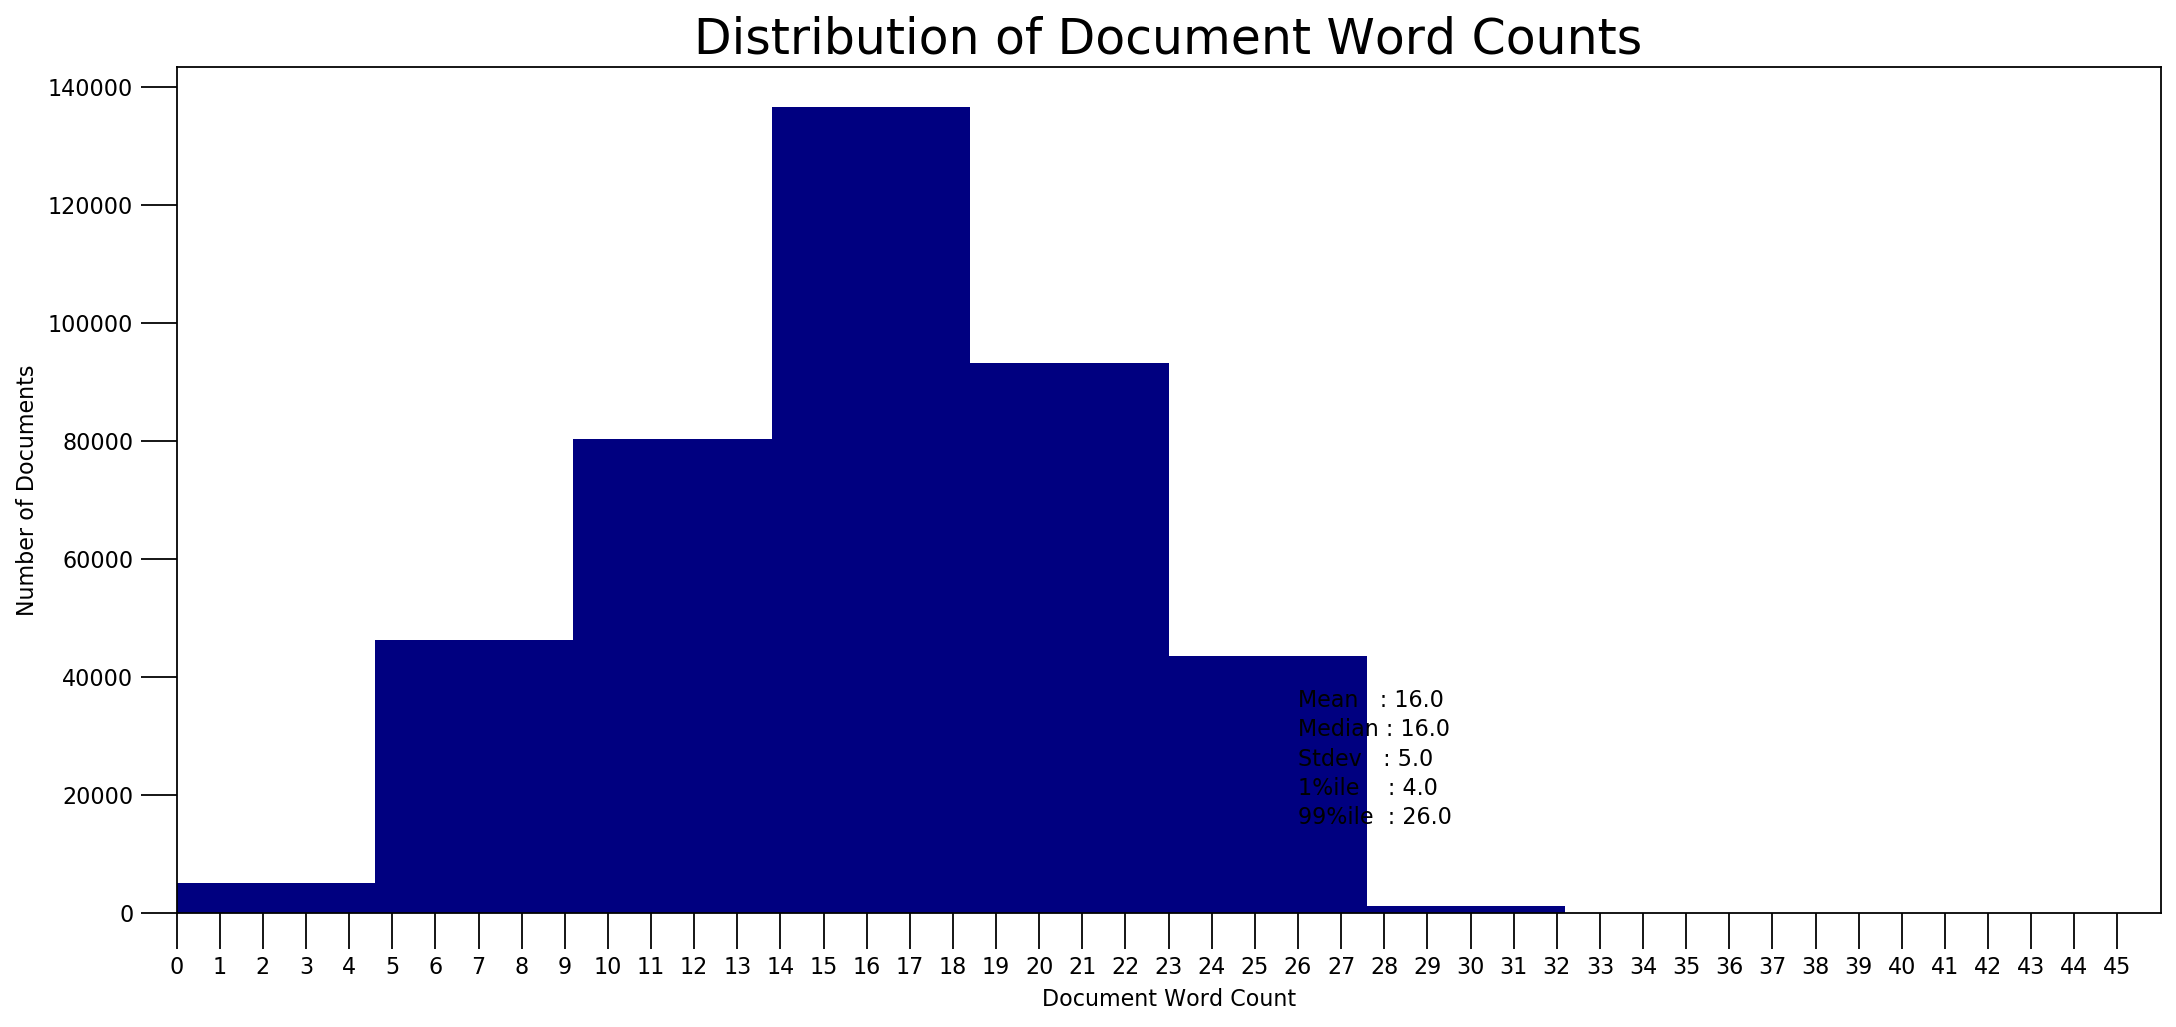

In [60]:
doc_lens = [len(d) for d in data_words]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, color='navy')
plt.text(26, 35000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(26, 30000, "Median : " + str(round(np.median(doc_lens))))
plt.text(26, 25000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(26, 20000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(26, 15000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, np.max(doc_lens)), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.arange(0,np.max(doc_lens)))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

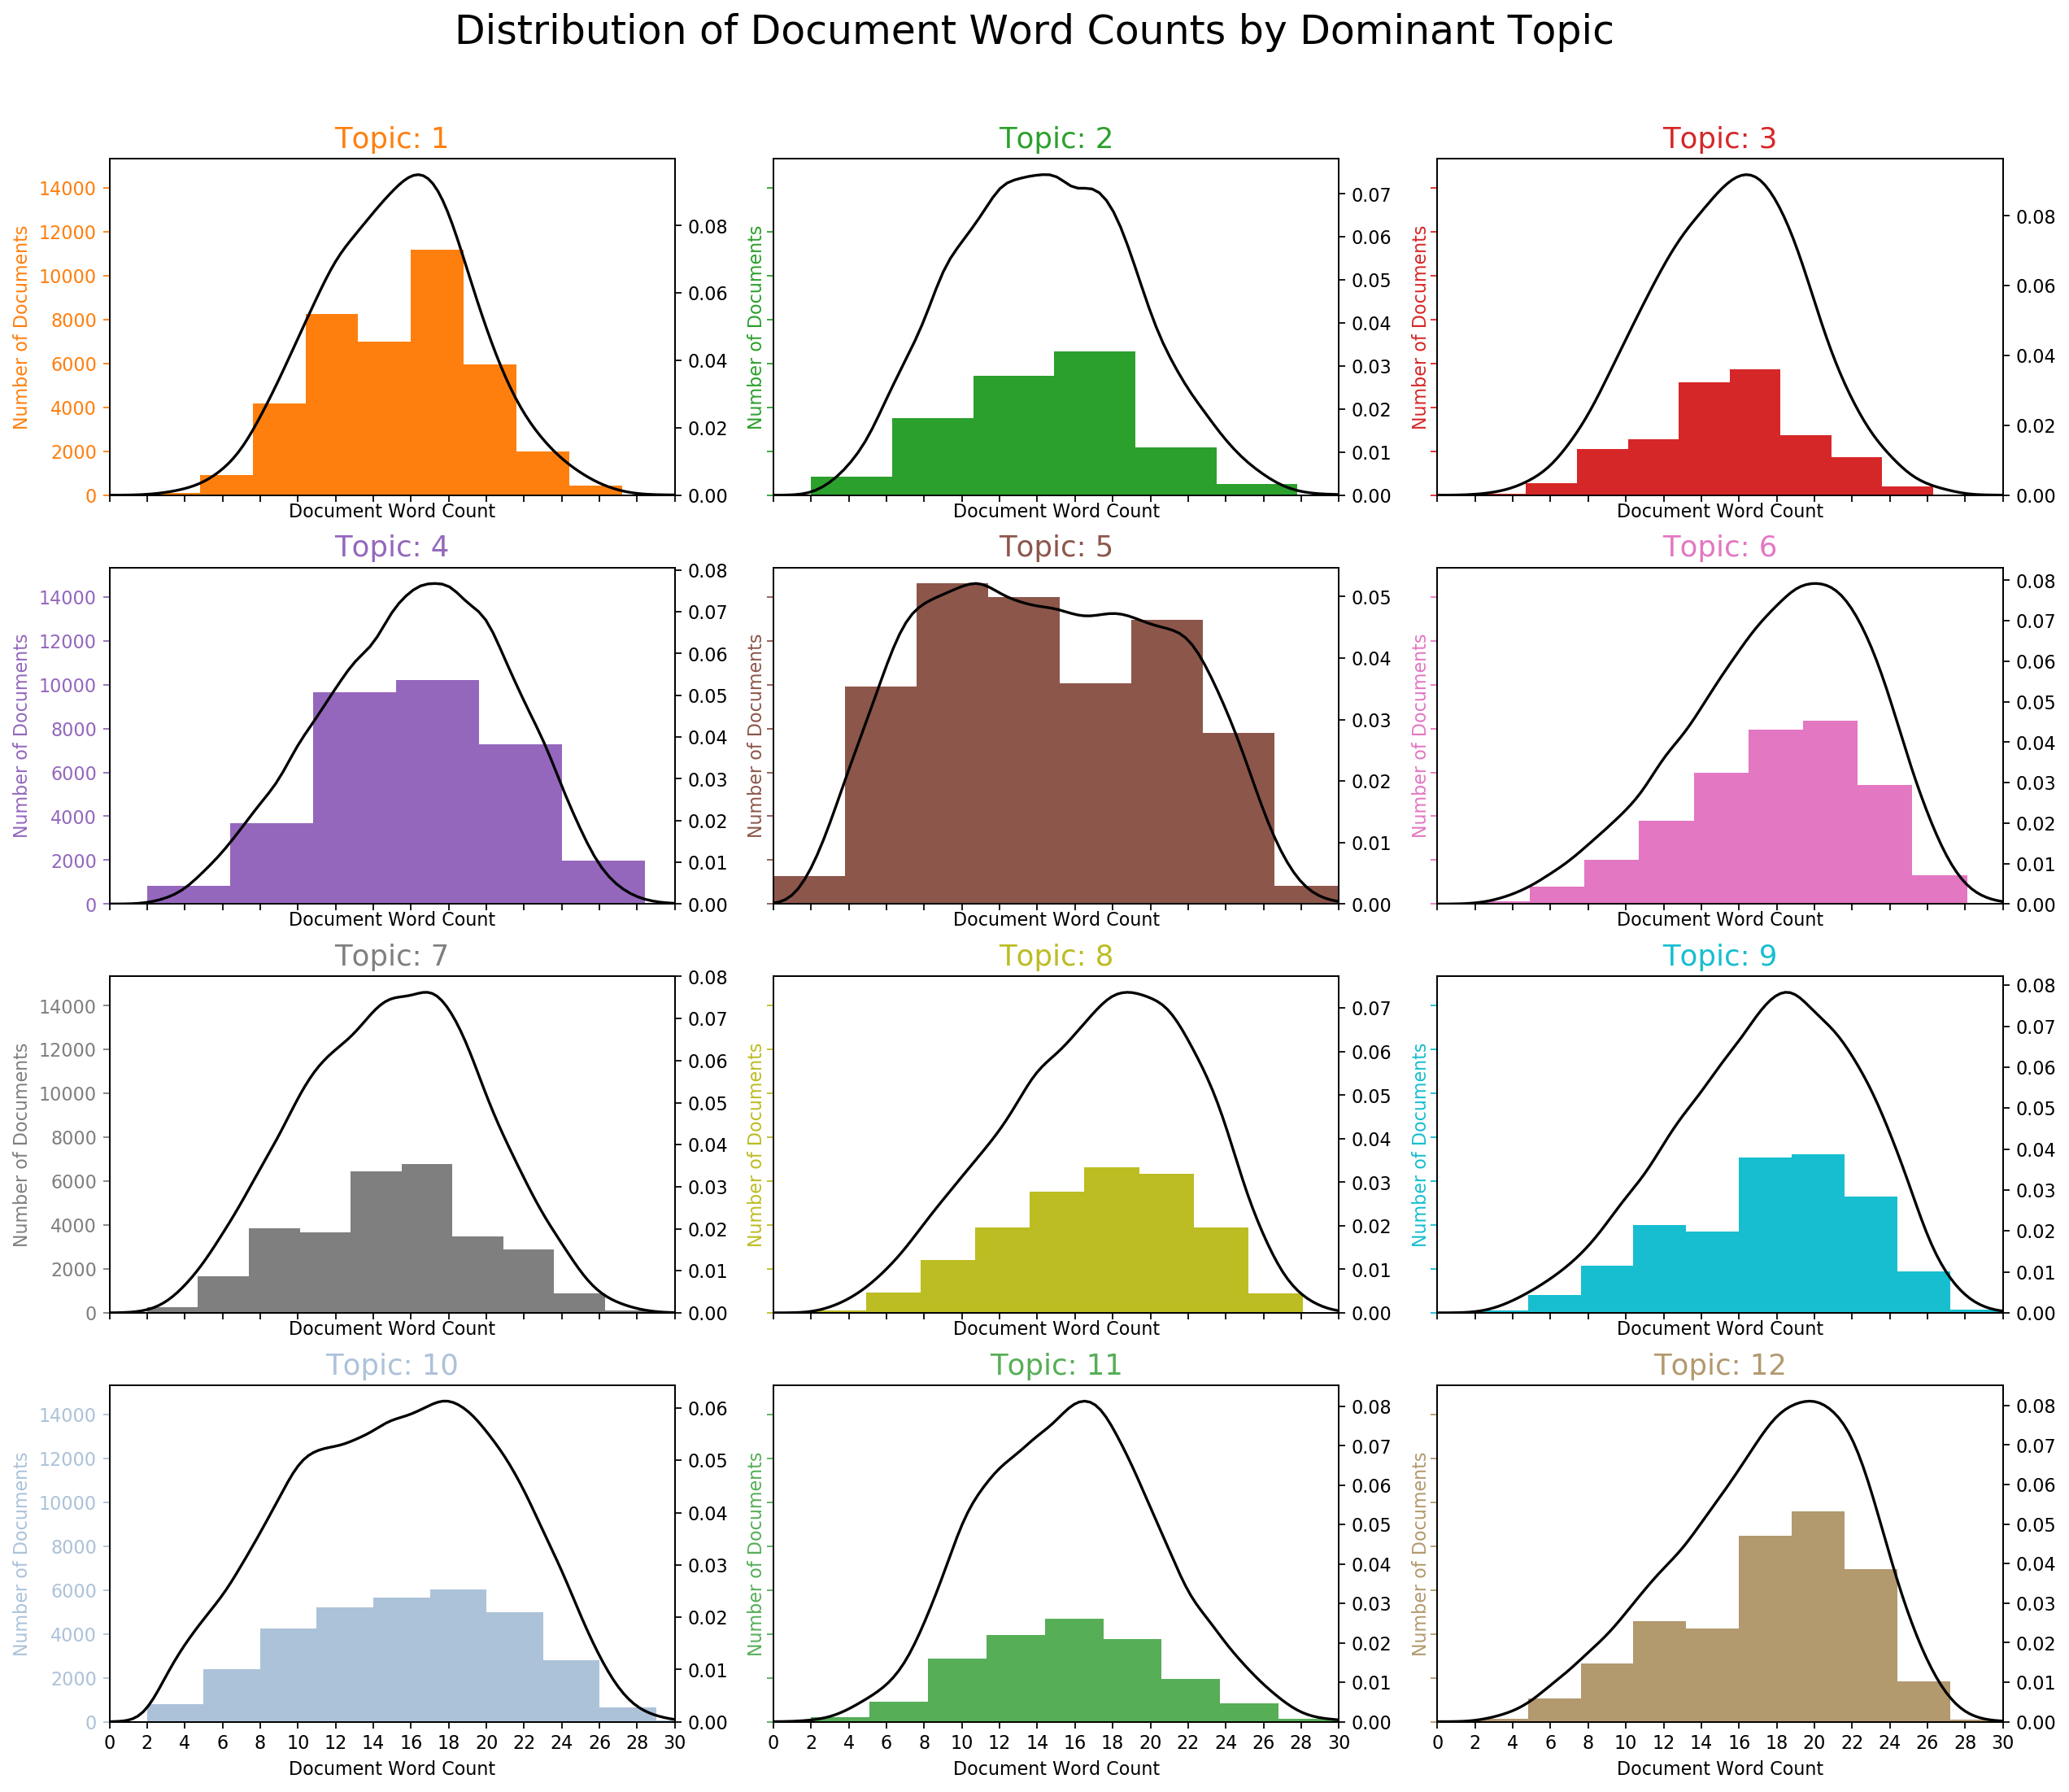

In [61]:
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

fig, axes = plt.subplots(4,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    i += 1
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Words]
    ax.hist(doc_lens, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, bw=0.8, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.arange(0, 32, 2))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Cloud

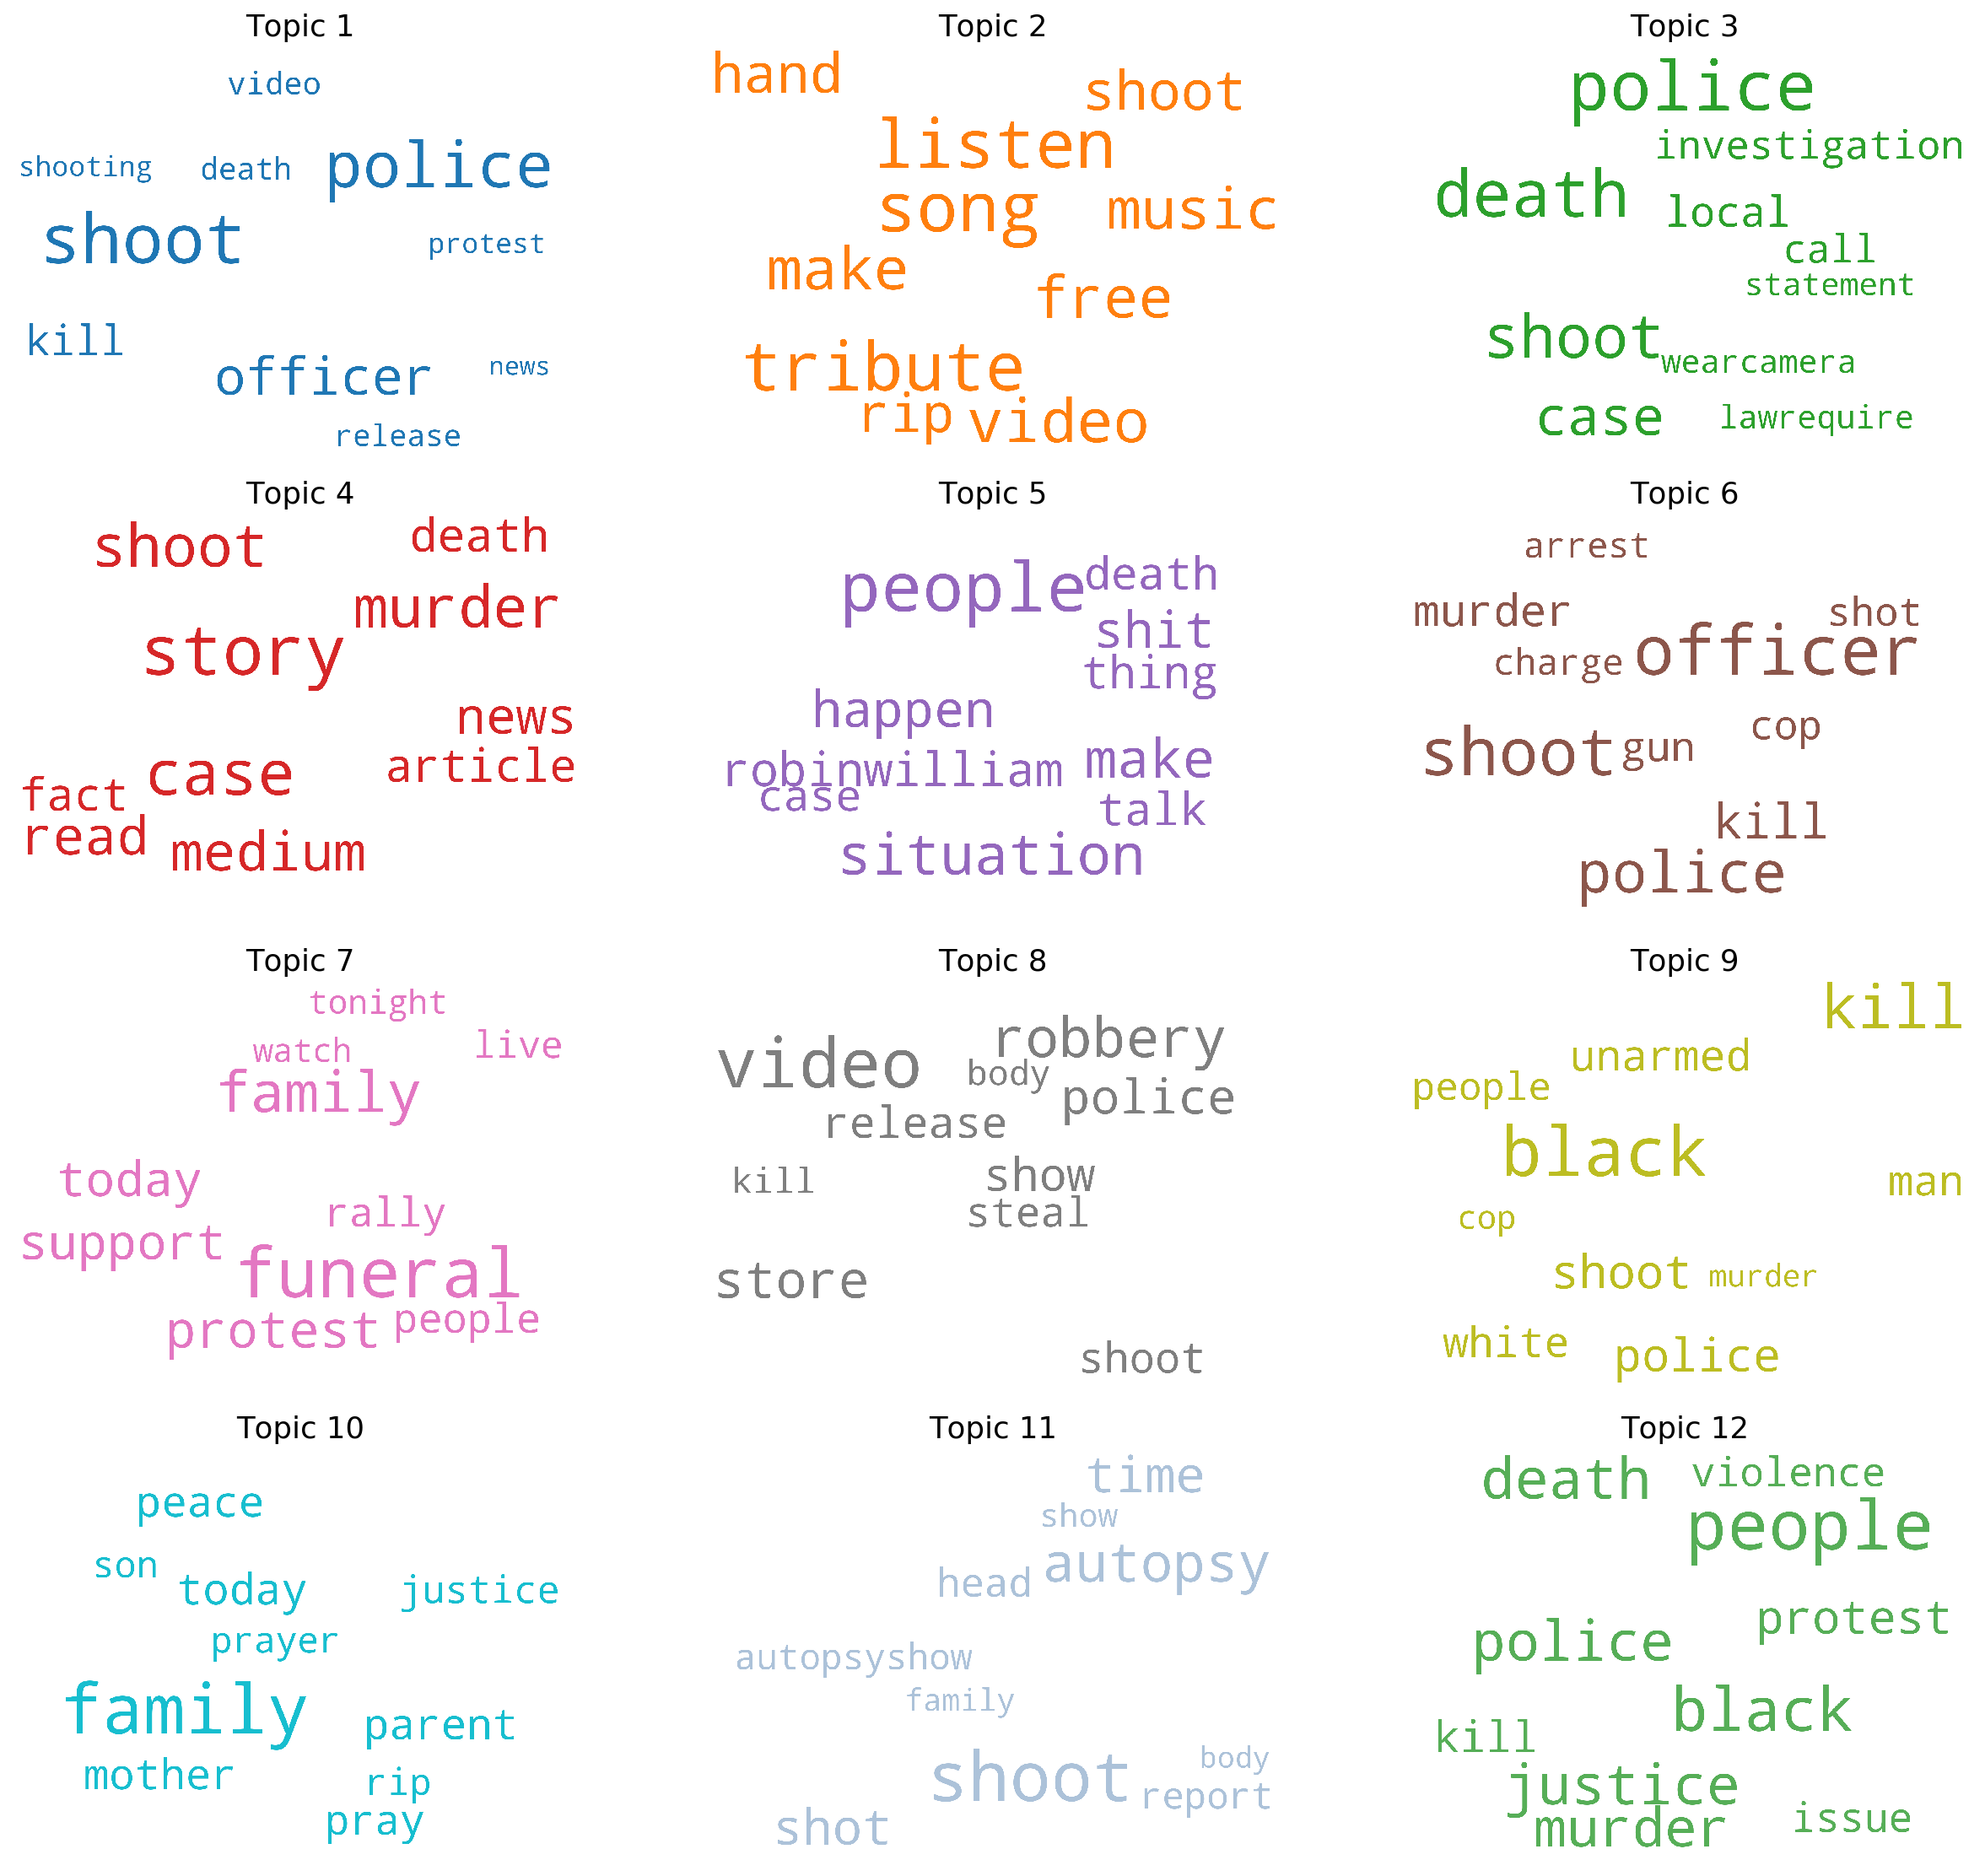

In [62]:
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(4, 3, figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word count of keywords

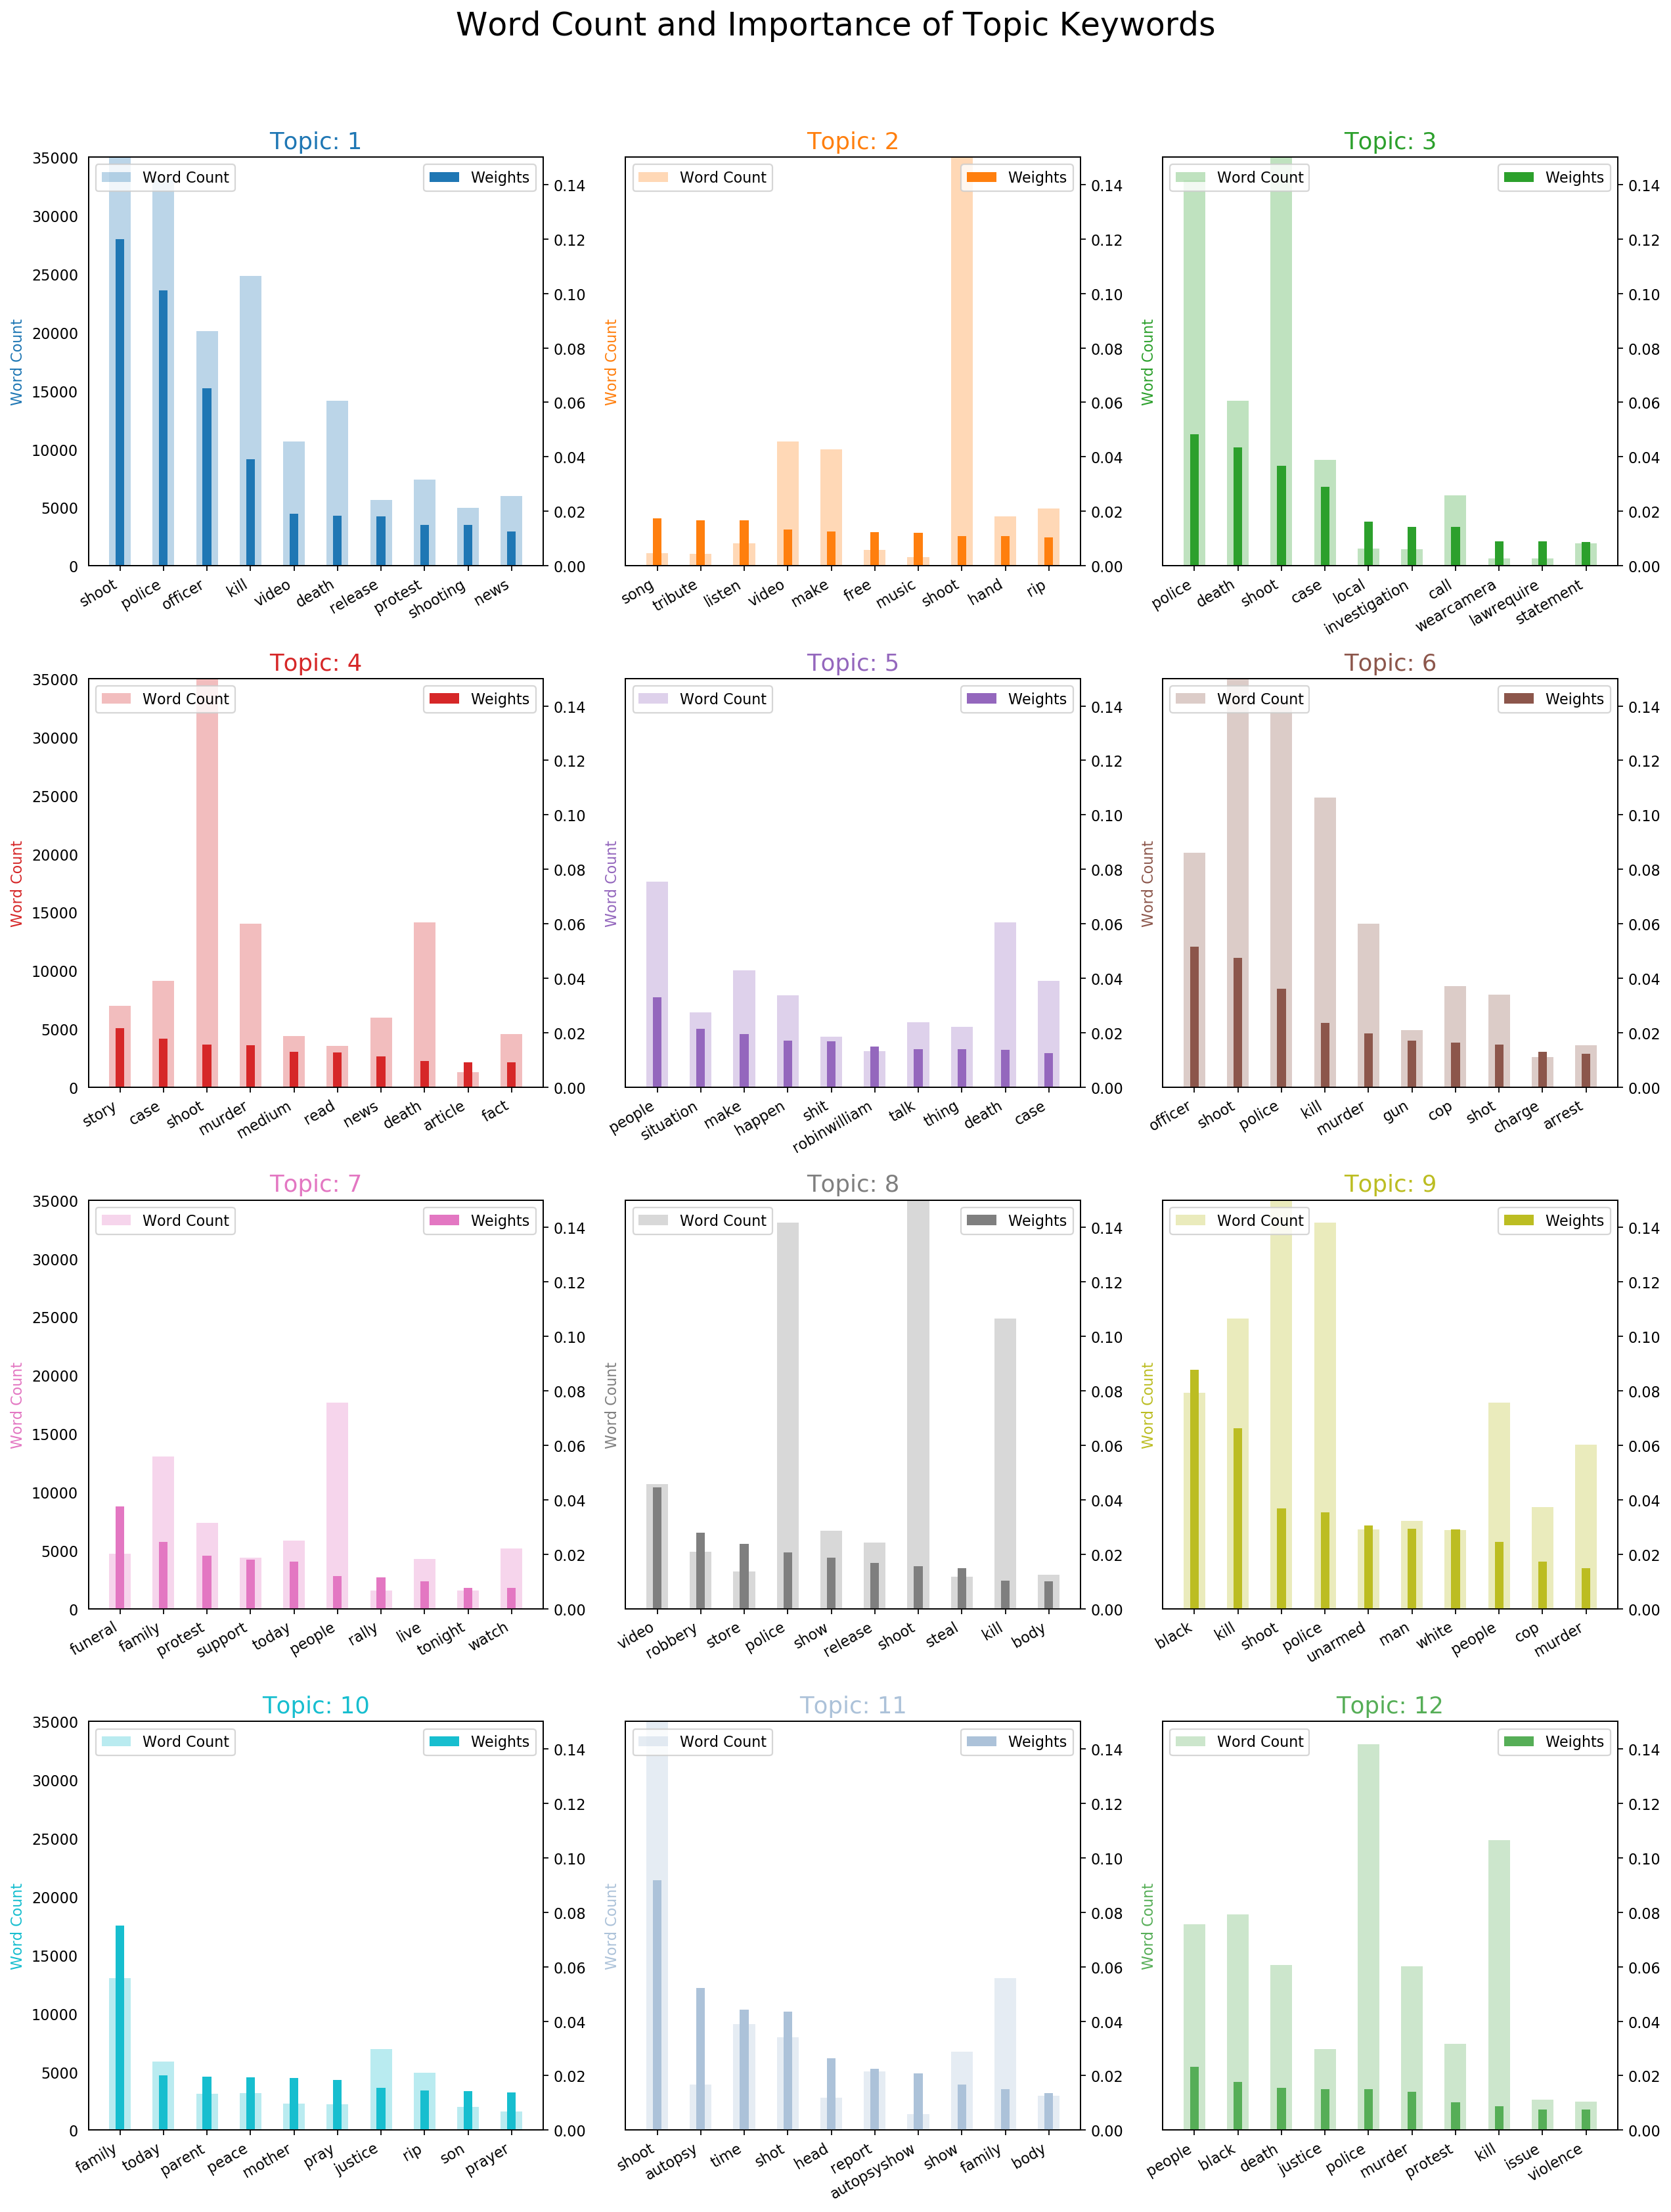

In [79]:
topics = optimal_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 3, figsize=(16,20), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.15); ax.set_ylim(0, 35000)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout()    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [64]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_, id2word, sort_topics=False, n_jobs=-1)
vis

/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([def

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.231155  0.078101  1       1        9.080091 
1      0.167841  0.136866  2       1        4.166767 
2     -0.064732  0.123230  3       1        4.976803 
3      0.029163 -0.020239  4       1        8.919855 
4      0.160948 -0.163873  5       1        12.939974
5     -0.191945 -0.123008  6       1        10.453453
6      0.180237  0.195425  7       1        6.776902 
7     -0.124935 -0.111584  8       1        8.533329 
8     -0.039162 -0.204666  9       1        9.720594 
9      0.237636  0.047631  10      1        7.768750 
10    -0.243455  0.184896  11      1        4.857679 
11     0.119559 -0.142779  12      1        11.805803, topic_info=      Category          Freq             Term         Total  loglift  logprob
term                                                                         
32     Default  58178.000000  shoot            58178.000000  30.0000  30.0000
39     Default  44418.000000  police           44418.000000  29.0000  29.0000
93     Default  23324.000000  black            23324.000000  28.0000  28.0000
30     Default  26627.000000  officer          26627.000000  27.0000  27.0000
165    Default  17567.000000  family           17567.000000  26.0000  26.0000
2      Default  32263.000000  kill             32263.000000  25.0000  25.0000
65     Default  14151.000000  video            14151.000000  24.0000  24.0000
33     Default  10670.000000  shot             10670.000000  23.0000  23.0000
192    Default  5688.000000   autopsy          5688.000000   22.0000  22.0000
16     Default  18701.000000  death            18701.000000  21.0000  21.0000
488    Default  6211.000000   funeral          6211.000000   20.0000  20.0000
19     Default  22022.000000  people           22022.000000  19.0000  19.0000
67     Default  8498.000000   white            8498.000000   18.0000  18.0000
42     Default  8732.000000   unarmed          8732.000000   17.0000  17.0000
51     Default  11809.000000  case             11809.000000  16.0000  16.0000
195    Default  12161.000000  time             12161.000000  15.0000  15.0000
52     Default  6264.000000   robbery          6264.000000   14.0000  14.0000
7      Default  4077.000000   store            4077.000000   13.0000  13.0000
162    Default  7814.000000   release          7814.000000   12.0000  12.0000
9      Default  9653.000000   man              9653.000000   11.0000  11.0000
315    Default  8066.000000   situation        8066.000000   10.0000  10.0000
660    Default  3866.000000   head             3866.000000   9.0000   9.0000 
242    Default  7796.000000   today            7796.000000   8.0000   8.0000 
209    Default  9714.000000   protest          9714.000000   7.0000   7.0000 
207    Default  6897.000000   report           6897.000000   6.0000   6.0000 
503    Default  3952.000000   robinwilliam     3952.000000   5.0000   5.0000 
464    Default  6445.000000   rip              6445.000000   4.0000   4.0000 
285    Default  3072.000000   mother           3072.000000   3.0000   3.0000 
63     Default  8784.000000   show             8784.000000   2.0000   2.0000 
344    Default  8831.000000   story            8831.000000   1.0000   1.0000 
43670  Topic1   1.472469      taxicab          1.472469      2.3991  -11.7092
21523  Topic1   4.417407      js               4.417407      2.3991  -10.6106
21603  Topic1   1.472469      wedemandjustice  1.472469      2.3991  -11.7092
21602  Topic1   13.252221     soonidentify     13.252221     2.3991  -9.5120 
21562  Topic1   1.472469      unmoleste        1.472469      2.3991  -11.7092
21554  Topic1   1.472469      someo            1.472469      2.3991  -11.7092
2506   Topic1   11.779752     deathviolate     11.779752     2.3991  -9.6298 
21538  Topic1   4.417407      frantic          4.417407      2.3991  -10.6106
21500  Topic1   5.889876      tcottpp          5.889876      2.3991  -10.3229
216

In [65]:
pyLDAvis.save_html(vis, 'pyLDAvis_only_brown.html')

## Upload table with tweet-topic

In [66]:
%%bigquery df_pred
SELECT 
    id,
    REGEXP_REPLACE(full_text_cleaned, "^rt ", "") AS full_text
FROM tweets.all_valid_tweets
WHERE ferguson_ht = 0 AND michael_brown = 1

In [67]:
df_pred

,id,full_text
0,499473944903450600,it doesnt even matter but to say that the michael brown story is being covered less than williams death is completely false
1,501390994592768000,girl shes trying to feed me this bull about mike brown robbing the store bitch it doesnt matter!!! that doesnt warrant death
2,500528804809703400,i’m watching looting of the liquor store where michael brown was accused of stealing cigars live on ipad right now woah this is nuts
3,498823715925532700,everything has an enemy then who what is the natural enemy 2 black man? mikebrown $URL$
4,498930266405367800,its time to get out in these streets and rearrange some furniture here in nyc too mikebrown ericgarner
5,501416139050987500,2 to the head and 4 to the arm nojusticenopeace michaelbrown
6,501937377531547650,“ i dont see any justice for mike brown pictures fuck yall $URL$ is just as bad …
7,500809226928021500,i want folks to remember that this is the 50th anniversary of freedom summer we are still protesting mikebrown johncr…
8,499895188626493440,im a trained sociologist explain this to me? mikebrown $URL$
9,500461607328047100,please consider not purchasing shirts of my image none of that money is going to me or the mikebrown family


In [68]:
data_pred = list(df_pred['full_text'])
ids_pred = list(df_pred['id'])

In [69]:
corpus_pred = create_corpus(data_pred)
df_topic_pred = format_topics_sentences(optimal_model, corpus_pred, data_pred)
df_topic_pred['id'] = ids_pred
df_topic_pred = df_topic_pred[['id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text']]

In [70]:
df_topic_pred

,id,Dominant_Topic,Topic_Perc_Contrib,Text
0,499473944903450600,4,0.9057,it doesnt even matter but to say that the michael brown story is being covered less than williams death is completely false
1,501390994592768000,5,0.6202,girl shes trying to feed me this bull about mike brown robbing the store bitch it doesnt matter!!! that doesnt warrant death
2,500528804809703400,8,0.8878,i’m watching looting of the liquor store where michael brown was accused of stealing cigars live on ipad right now woah this is nuts
3,498823715925532700,12,0.5016,everything has an enemy then who what is the natural enemy 2 black man? mikebrown $URL$
4,498930266405367800,5,0.4613,its time to get out in these streets and rearrange some furniture here in nyc too mikebrown ericgarner
5,501416139050987500,5,0.1358,2 to the head and 4 to the arm nojusticenopeace michaelbrown
6,501937377531547650,5,0.8716,“ i dont see any justice for mike brown pictures fuck yall $URL$ is just as bad …
7,500809226928021500,12,0.9089,i want folks to remember that this is the 50th anniversary of freedom summer we are still protesting mikebrown johncr…
8,499895188626493440,6,0.5612,im a trained sociologist explain this to me? mikebrown $URL$
9,500461607328047100,7,0.8620,please consider not purchasing shirts of my image none of that money is going to me or the mikebrown family


In [80]:
# Upload table with topic and contribution
# pandas_gbq.to_gbq(df_topic_pred, 'topic_modeling.topics_only_brown', project_id='dsi-capstone-f19-group-1')

1it [20:06, 1206.08s/it]
